# Learning to learn by gradient descent by gradient descent

Andrychowicz, Marcin, et al. "Learning to learn by gradient descent by gradient descent." Advances in Neural Information Processing Systems. 2016.

## Introduction

* Optimization
    * $\theta_{t+1}=\theta_t -\alpha_t \nabla f(\theta_t)$
* 많은 optimization algorithm 들이 제안되었지만 다 problem specific 함
    * 딥러닝 problem 에서는 ADAM, RMSProp, momentum 등등
* General 한 방법은 없을까?
* => 딥러닝에서 feature extractor 를 학습했던 것처럼 optimizer 도 학습하자!

우리가 학습할 모델 (NN 이라 생각하자) 을 f 라 하고, 이 f 를 학습시키기 위한 optimizer 를 g 라 할 때,  
즉 optimizer $g$ with parameter $\phi$, optimizee $f$:

$$\theta_{t+1}=\theta_t + g_t(\nabla f(\theta_t), \phi)$$

### Transfer learning and generalization

중요한 얘긴거 같은데 뭔소린지 모르겠다.

### Brief history and related work

마찬가지로 중요해 보임.

## Method

optimizer g 를 RNN 으로 모델링해보자.

Expected loss:

$$\mathcal L(\phi)=\mathbb E_f\left[ f(\theta^* (f, \phi)) \right]$$

그러나 GAN 에서 (이론적으론) 효율성을 위해 optimal D 를 학습하지 않고 1 step 씩 학습하는 것처럼, 여기서도 optimal theta $\theta^*$ 를 학습하지 않는다:

$$\mathcal L(\phi)=\mathbb E_f \left[ \sum^T_{t=1} w_t f(\theta_t) \right]$$

where

- $\theta_{t+1}=\theta_t+g_t$
- $g_t, h_{t+1} = m(\nabla_t, h_t, \phi)$
    - g 는 optimizer, h 는 RNN 의 hidden state
    - $\nabla_t=\nabla_\theta f(\theta_t)$
    
위 식에서 $w_t=1[t=T]$ 로 두면 original loss function 과 동일해진다 (물론 T 가 굉장히 클 때 그리고 이 때 optimal 을 찾는다는 가정하에서 얘기긴 함 - 그래서 논문에서는 T 를 some horizon T 라고 말함). 그러나 계산상의 효율성을 위해 모든 w=1 로 두었다. 즉 GAN 처럼 step by step 으로 하나씩 업데이트.

## Questions

- 로스를 계산하기 위해 f 에 대해 expectation 을 하는데... 이론적으로는 뭘 하고자 하는지 알것 같은데, 잘 감이 안 옴. 실제 구현때는 어떻게 하지 이걸?

In [1]:
import tensorflow as tf

In [3]:
# problem setting - 1. quadratic function
# `optimizee` f - ref 에서는 error landscape 로 생각하는게 더 정확하다는데,
# 이는 이 quadratic function 은 말 그대로 function optimization 이기 때문이다.
# NN 이 아니라 f 의 최적값을 찾는 것. 따라서 f(x) 자체가 로스가 됨

scale = tf.random_uniform([10], minval=0.5, maxval=1.5)
def f(x):
    x = scale*x
    return tf.reduce_sum(x*x) # quadratic function

In [13]:
# 이유는 잘 모르겠지만 built-in SGD, RMSProp 을 쓰면 안 된대.

def g_sgd(gradients, state, learning_rate=0.1):
    return -learning_rate*gradients, state


def g_rms(gradients, state, learning_rate=0.1, decay_rate=0.99):
    if state is None:
        state = tf.zeros(10)
    state = decay_rate*state + (1-decay_rate)*tf.pow(gradients, 2)
    update = -learning_rate*gradients / (tf.sqrt(state)+1e-5)
    return update, state

In [14]:
# unrolling - RNN unrolling 얘기가 아님
T = 20
start_pos = tf.random_uniform([10], -1., 1.)

def learn(optimizer):
    losses = []
    x = start_pos
    state = None
    
    for _ in range(T):
        loss = f(x)
        losses.append(loss)
        grads_vars = tf.gradients(loss, x)
        update, state = optimizer(grads_vars[0], state)
        x += update
    
    return losses

In [15]:
sgd_losses = learn(g_sgd)
rms_losses = learn(g_rms)

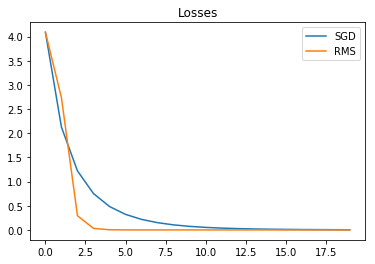

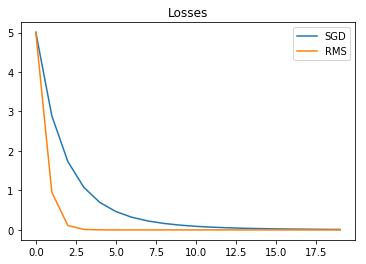

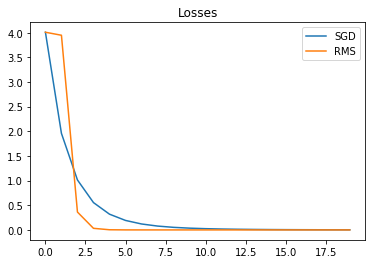

In [17]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

x = np.arange(T)
for _ in range(3): 
    sgd_l, rms_l = sess.run([sgd_losses, rms_losses])
    p1, = plt.plot(x, sgd_l, label='SGD')
    p2, = plt.plot(x, rms_l, label='RMS')
    plt.legend(handles=[p1, p2])
    plt.title('Losses')
    plt.show()

## Meta-learning

In [18]:
n_layers = 2
n_units = 20

cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(n_units) for _ in range(n_layers)])
cell = tf.contrib.rnn.InputProjectionWrapper(cell, n_units)
cell = tf.contrib.rnn.OutputProjectionWrapper(cell, 1)
cell = tf.make_template('cell', cell)

In [30]:
def g_rnn(gradients, state):
    # Make a `batch' of single gradients to create a 
    # "coordinate-wise" RNN as the paper describes. 
    gradients = tf.expand_dims(gradients, axis=1)
 
    if state is None:
        state = [[tf.zeros([10, n_units])] * 2] * n_layers
    update, state = cell(gradients, state)
    # Squeeze to make it a single batch again.
    squeeze = tf.squeeze(update, axis=[1])
    print update.shape, squeeze.shape
    return squeeze, state

In [31]:
rnn_losses = learn(g_rnn)
sum_losses = tf.reduce_sum(rnn_losses)

(10, 1) (10,)
(10, 1) (10,)
(10, 1) (10,)
(10, 1) (10,)
(10, 1) (10,)
(10, 1) (10,)
(10, 1) (10,)
(10, 1) (10,)
(10, 1) (10,)
(10, 1) (10,)
(10, 1) (10,)
(10, 1) (10,)
(10, 1) (10,)
(10, 1) (10,)
(10, 1) (10,)
(10, 1) (10,)
(10, 1) (10,)
(10, 1) (10,)
(10, 1) (10,)
(10, 1) (10,)


In [25]:
def optimize(loss):
    optimizer = tf.train.AdamOptimizer(0.0001)
    # meta-learner 의 로스가 초반에 굉장히 커서 그라디언트 클리핑이 중요하다는데...
    gradients, v = zip(*optimizer.compute_gradients(loss))
    gradients, _ = tf.clip_by_global_norm(gradients, 1.)
    return optimizer.apply_gradients(zip(gradients, v))

apply_update = optimize(sum_losses)

In [26]:
sess.run(tf.global_variables_initializer())

ave = 0
for i in range(4000):
    err, _ = sess.run([sum_losses, apply_update])
    ave += err
    if i % 1000 == 0:
        print(ave / 1000 if i!=0 else ave)
        ave = 0
print(ave / 1000)

30.9660568237
10.2357930181
3.96888575649
3.99377181375
3.94776755047


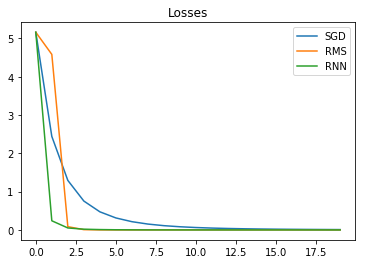

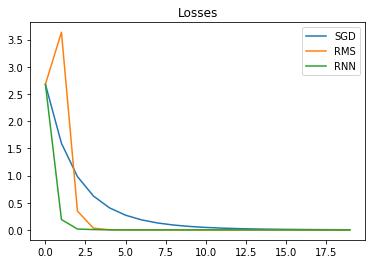

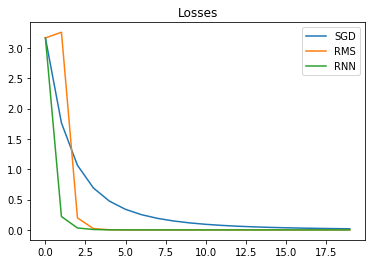

In [27]:
for _ in range(3): 
    sgd_l, rms_l, rnn_l = sess.run(
        [sgd_losses, rms_losses, rnn_losses])
    p1, = plt.plot(x, sgd_l, label='SGD')
    p2, = plt.plot(x, rms_l, label='RMS')
    p3, = plt.plot(x, rnn_l, label='RNN')
    plt.legend(handles=[p1, p2, p3])
    plt.title('Losses')
    plt.show()